## Imports

In [3]:
import torch
from torch.nn import MSELoss

if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    print('Using MPS')
    device = torch.device("mps")
elif torch.backends.cuda.is_built():
    print('Using CUDA')
    device = torch.device("cuda")
else:
    print('Using CPU')
    device = torch.device("cpu")

Using MPS


In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

## Main Load

In [4]:
csv = pd.read_csv('data/user_data_public.csv', low_memory=False)

In [4]:
filtered_df = csv.loc[:, ~csv.columns.str.match(r'^q\d+')]

In [ ]:
# f = filtered_df.d_country.value_counts().where(filtered_df.d_country.value_counts() > 100)

## A Little Experiment - Checking bodytype v sexual orientation correlations in Men

In [ ]:
import numpy as np

# Filtering NA
bodytype_orientation = filtered_df[['d_bodytype', 'd_orientation', 'gender']].dropna()

# Filtering men only
bodytype_orientation = bodytype_orientation[
    (bodytype_orientation.gender == 'Man') & (bodytype_orientation.d_bodytype != 'Rather not say')].drop(
    columns=['gender'])

bodytype_orientation.d_orientation.unique()
# Distinguishing likely homosexual group from rest of men. Identified ['Gay', 'Gay, Queer', 'Gay, Sapiosexual'] as potential homosexual groups. Others  varied

potential_homosexual_groups = ['Gay', 'Gay, Queer']
# bodytype_orientation = bodytype_orientation[bodytype_orientation.d_orientation.isin(potential_homosexual_groups + ['Straight'])]

# Create the new column with 'h' for homosexual and 'o' for others
bodytype_orientation['d_orientation'] = np.where(
    bodytype_orientation['d_orientation'].isin(potential_homosexual_groups),
    'h',
    'o'
)
bodytype_orientation.value_counts()

In [ ]:
(bodytype_orientation[
     bodytype_orientation.d_bodytype == 'Jacked'].d_orientation.value_counts() / bodytype_orientation.d_orientation.value_counts())

In [ ]:
bodytype_orientation.d_orientation.value_counts()
# bodytype_orientation[bodytype_orientation.d_bodytype == 'Overwight'].value_counts() / bodytype_orientation.d_orientation.value_counts()

## Mixed Matchmaking

In [ ]:
csv[csv.q71 == 'Yes'].race.value_counts() / csv[csv.q71.isin(['Yes', 'No'])].race.value_counts()

In [ ]:
religions_csv = csv[['q71', 'd_religion_type', 'gender', 'race']].dropna(subset=['d_religion_type', 'q71'])
religions_csv = religions_csv[religions_csv['d_religion_type'] != '-']
religions_csv.d_religion_type.value_counts()

In [ ]:
bad_idea_boolean = religions_csv.q71 == 'Yes'

In [ ]:
religions_csv[bad_idea_boolean].d_religion_type.value_counts() / religions_csv.d_religion_type.value_counts()

## Police/Coutnry Safety

In [ ]:
# q6109
safety = csv[['q6109', 'race', 'gender', 'd_country']].dropna(subset='q6109')

In [ ]:
safety

## PCA

In [31]:
import random
from sklearn.preprocessing import StandardScaler

df = filtered_df.drop(columns=['CA', 'CA_items'])  # Remove uninterpreted columns
df = df.dropna(subset=['d_gender', 'd_age', 'p_ambi'])  # Core features

# Encode categoricals
cat_cols = ['d_astrology_sign', 'd_education_type', 'd_ethnicity']
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Normalize personality traits
p_cols = [c for c in df.columns if c.startswith('p_')]
scaler = StandardScaler()
df[p_cols] = scaler.fit_transform(df[p_cols].fillna(df[p_cols].mean()))

In [33]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# PCA for visualization
pca = PCA(n_components=0.95)
pca_features = pca.fit_transform(df[p_cols])

# t-SNE for cluster separation
tsne = TSNE(n_components=2, perplexity=30)
tsne_results = tsne.fit_transform(pca_features)


/Users/david/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/david/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [34]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# Determine optimal clusters
silhouette_scores = []
for k in range(2, 8):
    kmeans = KMeans(n_clusters=k)
    labels = kmeans.fit_predict(pca_features)
    silhouette_scores.append(silhouette_score(pca_features, labels))

# Final clustering
optimal_k = np.argmax(silhouette_scores) + 2
kmeans = KMeans(n_clusters=optimal_k)
df['cluster'] = kmeans.fit_predict(pca_features)


In [35]:
# Cluster characteristics
cluster_profiles = df.groupby
cluster_profiles

<bound method DataFrame.groupby of              p_conf        d_astrology_seriosity    p_laidback  \
3     -6.539848e-16                          NaN  9.601352e-16   
5     -6.539848e-16        but it doesn't matter  9.601352e-16   
6     -6.539848e-16                          NaN  9.601352e-16   
22    -6.539848e-16  and it's fun to think about  9.601352e-16   
23    -6.539848e-16                          NaN  9.601352e-16   
...             ...                          ...           ...   
68363 -6.539848e-16  and it's fun to think about -4.200165e-02   
68364 -6.539848e-16  and it's fun to think about  9.601352e-16   
68365 -6.539848e-16                          NaN -2.879669e+00   
68369 -6.539848e-16                          NaN  9.601352e-16   
68370 -6.539848e-16                          NaN  9.601352e-16   

      d_education_phase  p_drug  \
3            Working on     0.0   
5        Dropped out of     0.0   
6            Working on     0.0   
22                  NaN     0.0 

## Top Questions

In [5]:
import pandas as pd

# Read the data
question_csv = pd.read_csv('data/question_data.csv', delimiter=';', low_memory=False)


In [33]:
# Get high-response questions
question_cols = list(
    filter(lambda st: st[0] == 'q', question_csv.loc[question_csv.N > 50000, 'question'].dropna().tolist()))

# Drop rows in csv with any NaNs in selected question columns
answerers = csv.dropna(subset=question_cols)

# Subset the answer columns
answers_raw = answerers[question_cols]

# One-hot encode categorical answers
answers_encoded = pd.get_dummies(answers_raw, columns=question_cols)

# Add age as target
answers_encoded['d_age'] = answerers.loc[answers_encoded.index, 'd_age']

In [7]:
# question_cols = list(filter(lambda st: st[0] == 'q', question_csv.loc[question_csv.N > 45000, 'question'].dropna().tolist()))
# question_cols

In [8]:
# answerers = csv.dropna(subset=question_cols)
# answers = answerers[question_cols + ['d_age']]
# answerers

### Creating the data loaders

In [104]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader


# Custom dataset class
class QuestionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X.values)
        self.y = torch.FloatTensor(y.values)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# Drop rows with NaNs in features or target before splitting
clean_data = answers_encoded.dropna(subset=answers_encoded.columns.tolist() + ['d_age'])

X = clean_data.drop(columns='d_age')
y = clean_data['d_age']

X_train, X_test, y_train, y_test = train_test_split(X, np.log1p(y), test_size=0.2, random_state=42)

# Create and apply scaler
age_scaler = StandardScaler()
y_train_scaled = age_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = age_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Create datasets
train_dataset = QuestionDataset(X_train, pd.Series(y_train_scaled))
test_dataset = QuestionDataset(X_test, pd.Series(y_test_scaled))

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [105]:
y_test

61543    3.401197
42858    3.637586
24491    3.135494
26502    3.367296
8649     3.218876
           ...   
49196    3.433987
56794    3.401197
28197    3.465736
43857    3.583519
67526    3.465736
Name: d_age, Length: 5198, dtype: float64

### Training the model

In [107]:
import torch
import torch.nn as nn
import torch.optim as optim


# Neural network model
class AgePredictor(nn.Module):
    def __init__(self, input_size):
        super(AgePredictor, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.layers(x)

    # Fix this method (just paste this)
    def predict(self, X):
        with torch.no_grad():
            X = torch.FloatTensor(X).to(device)
            preds_scaled = self(X).cpu().numpy().reshape(-1, 1)
            # Inverse scaling
            preds_log = age_scaler.inverse_transform(preds_scaled).flatten()
            # Inverse np.log1p: recover actual ages
            preds_age = np.expm1(preds_log)
            return preds_age

In [116]:
# Initialize model, loss and optimizer
model = AgePredictor(X_train.shape[1]).to(device)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
# Training loop

num_epochs = 10
# Compute total steps
total_steps = num_epochs * (len(train_loader) + len(test_loader))
progress_bar = tqdm(total=total_steps, desc="Training Progress", leave=False)
for epoch in range(num_epochs):
    model.train()
    train_loss_total = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()

        train_loss_total += loss.item()
        progress_bar.update(1)
        progress_bar.set_description(f"Epoch {epoch + 1}/{num_epochs} [Train]")
        progress_bar.set_postfix(loss=loss.item())

    model.eval()
    val_loss_total = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets).item()
            val_loss_total += loss
            progress_bar.update(1)
            progress_bar.set_description(f"Epoch {epoch + 1}/{num_epochs} [Val]")
            progress_bar.set_postfix(loss=loss)

    # Print epoch summary
    print(f"Epoch {epoch + 1}/{num_epochs} - "
          f"Train Loss: {train_loss_total / len(train_loader):.4f} | "
          f"Val Loss: {val_loss_total / len(test_loader):.4f}")

progress_bar.close()

Training Progress:   0%|          | 0/4070 [00:00<?, ?it/s]

Epoch 1/10 - Train Loss: 0.7396 | Val Loss: 0.7116
Epoch 2/10 - Train Loss: 0.7213 | Val Loss: 0.7115
Epoch 3/10 - Train Loss: 0.7172 | Val Loss: 0.7084
Epoch 4/10 - Train Loss: 0.7143 | Val Loss: 0.7099
Epoch 5/10 - Train Loss: 0.7134 | Val Loss: 0.7073
Epoch 6/10 - Train Loss: 0.7108 | Val Loss: 0.7089
Epoch 7/10 - Train Loss: 0.7099 | Val Loss: 0.7093
Epoch 8/10 - Train Loss: 0.7088 | Val Loss: 0.7111
Epoch 9/10 - Train Loss: 0.7021 | Val Loss: 0.7082
Epoch 10/10 - Train Loss: 0.7039 | Val Loss: 0.7102


### Plotting a sample test

Sample 1 — True Age: 47.0, Predicted Age: 33.7
Sample 2 — True Age: 33.0, Predicted Age: 30.0
Sample 3 — True Age: 30.0, Predicted Age: 28.6
Sample 4 — True Age: 23.0, Predicted Age: 26.7
Sample 5 — True Age: 21.0, Predicted Age: 31.7
Sample 6 — True Age: 43.0, Predicted Age: 32.6
Sample 7 — True Age: 34.0, Predicted Age: 31.6
Sample 8 — True Age: 33.0, Predicted Age: 33.1
Sample 9 — True Age: 28.0, Predicted Age: 32.4
Sample 10 — True Age: 37.0, Predicted Age: 25.1
Sample 11 — True Age: 30.0, Predicted Age: 39.3
Sample 12 — True Age: 38.0, Predicted Age: 36.4
Sample 13 — True Age: 39.0, Predicted Age: 33.7
Sample 14 — True Age: 29.0, Predicted Age: 35.3
Sample 15 — True Age: 40.0, Predicted Age: 34.0
Train MAE: 5.38
Test MAE: 5.50


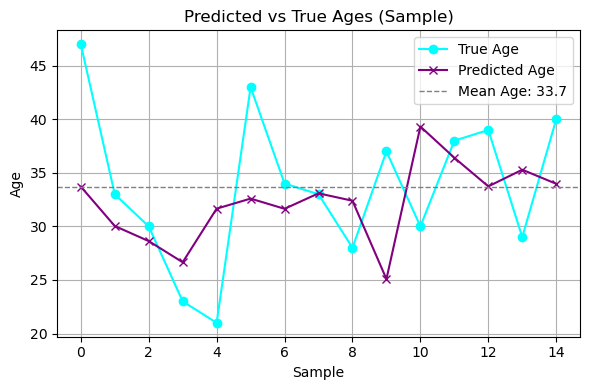

In [145]:
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error as mae

model.eval()
with torch.no_grad():
    train_preds = model.predict(X_train.values)
    test_preds = model.predict(X_test.values)

train_mae = mae(np.expm1(y_train.values), train_preds)
test_mae = mae(np.expm1(y_test.values), test_preds)


sample_X = X_test.sample(15, random_state=69)
sample_true_ages = np.expm1(y_test.loc[sample_X.index].values)
model.eval()
with torch.no_grad():
    outputs = model.predict(sample_X.values)
for i, (true_age, pred_age) in enumerate(zip(sample_true_ages, outputs)):
    print(f"Sample {i + 1} — True Age: {true_age:.1f}, Predicted Age: {pred_age:.1f}")

print(f"Train MAE: {train_mae:.2f}")
print(f"Test MAE: {test_mae:.2f}")

plt.figure(figsize=(6, 4))
plt.plot(sample_true_ages, label='True Age', marker='o', color='cyaN')
plt.plot(outputs, label='Predicted Age', marker='x', color='purple')
plt.axhline(sample_true_ages.mean(), color='gray', linestyle='--', linewidth=1,
            label=f'Mean Age: {sample_true_ages.mean():.1f}')
plt.title('Predicted vs True Ages (Sample)')
plt.legend()
plt.xlabel('Sample')
plt.ylabel('Age')
plt.grid(True)
plt.tight_layout()
plt.show()


### Testing mean and median errors

In [136]:

actual_ages = np.expm1(y_test.values)
mean_predictor = np.full_like(actual_ages, actual_ages.mean())
median_predictor = np.full_like(actual_ages, np.median(actual_ages))

mean_mse = mae(actual_ages, mean_predictor)
median_mse = mae(actual_ages, median_predictor)

print(f"MSE using mean ({actual_ages.mean():.2f}) as predictor: {mean_mse:.2f}")
print(f"MSE using median ({np.median(actual_ages):.2f}) as predictor: {median_mse:.2f}")

MSE using mean (32.65) as predictor: 6.10
MSE using median (32.00) as predictor: 6.04


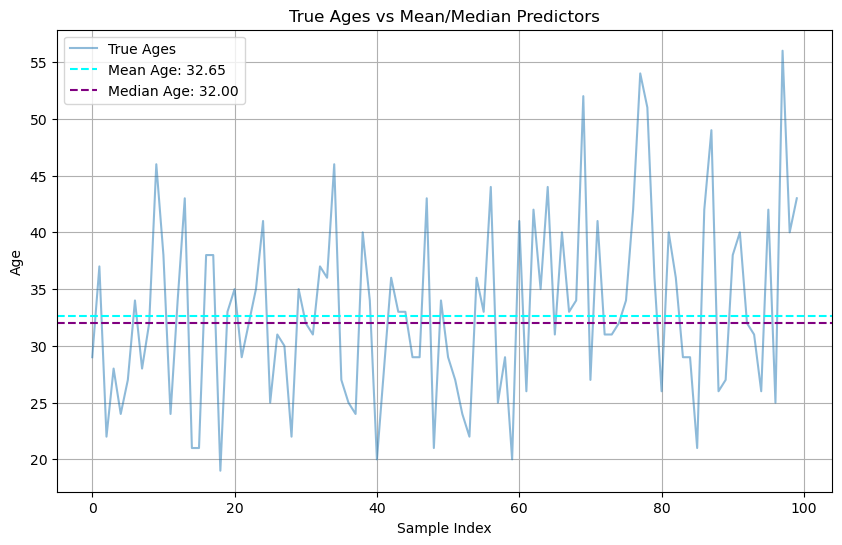

In [142]:
plt.figure(figsize=(10, 6))
plt.plot(actual_ages[:100], label='True Ages', alpha=0.5)
plt.axhline(y=actual_ages.mean(), color='cyaN', linestyle='--', label=f'Mean Age: {actual_ages.mean():.2f}')
plt.axhline(y=np.median(actual_ages), color='purple', linestyle='--', label=f'Median Age: {np.median(actual_ages):.2f}')
plt.title('True Ages vs Mean/Median Predictors')
plt.xlabel('Sample Index')
plt.ylabel('Age')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
train_loader.sampler